# <center>Анализ результатов моделей и интерпретация

Для оценки необходимости отцепки вагона в плановый ремонт можно опираться как на анализ текущих характеристик вагона (см. результаты в notebooks/data_analysis), так и использовать методы машинного обучения. В результате работы были получены инструменты предварительного анализа данных, а также методы интерпретации результатов моделей.

In [50]:
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import shap
from wagon_package import prediction_cols

import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
cat_cols = [
    'wagnum', 'model', 'kuzov', 'telega', 
    'tipvozd', 'tippogl', 'norma_km', 'reestr_state'
]

In [120]:
df = pd.read_csv('evaluation_data/features.csv')
df['reestr_state'] = df['reestr_state'].astype(int)

## 1. Анализ входных данных модели

Перед построением моделей машинного обучения были рассмотрены взаимосвязи между признаками и исключены признаки, имеющие среднеквадратичное отклонение, равное нулю, а также признаки с выосокй корреляции. Также для модели были отобраны признаки, предварительный анализ которых показал наличие взаимовязи с целевой переменной.

In [122]:
corr = df[prediction_cols].corr()
corr.style.background_gradient(cmap='coolwarm')

,wagnum,last_dep,last_kap,nearest_pl,wag_age,wag_remains,rod_id,gruz,cnsi_volumek,cnsi_probeg_dr,kuzov,telega,tipvozd,tippogl,norma_km,zavod_build,gr_probeg,por_probeg,tr_rems,pr_rems,gr_distance,por_distance,isload,current_skoroport,current_naval,current_naliv,current_openvagons,current_soprovod,current_smerz,ost_prob,reestr_state,mileage_all,flange_sum,rim_sum,target_month_lag1,target_day_lag1
wagnum,1.000000,-0.255264,0.014474,-0.031915,-0.168206,-0.223409,0.699042,0.620219,-0.675341,-0.050097,0.024605,-0.223827,-0.048905,0.212311,-0.105509,-0.204735,0.069147,0.155738,0.021366,0.084347,0.039474,0.023280,0.035106,-0.105781,0.425408,-0.076295,0.178476,-0.033608,0.021629,-0.018365,-0.002488,0.054454,0.057245,0.056951,0.090627,0.053794
last_dep,-0.255264,1.000000,0.011911,-0.114142,-0.328189,0.455894,-0.259596,-0.141095,0.312352,-0.329984,0.392788,0.442139,0.440728,0.113820,-0.042219,-0.066602,0.002411,-0.039002,-0.040696,0.026702,-0.021387,-0.015717,-0.010456,0.038865,-0.167490,0.029844,-0.068161,0.075795,-0.011029,0.115705,-0.041243,-0.047556,-0.044453,-0.041980,0.032585,0.020350
last_kap,0.014474,0.011911,1.000000,-0.140356,-0.433989,0.532472,-0.250215,-0.152606,0.344899,-0.153645,-0.068255,0.383810,0.392358,0.070338,-0.069262,0.143471,-0.026610,-0.053475,-0.047107,0.023462,-0.009928,-0.009318,0.013416,0.053432,-0.137162,0.032414,-0.064356,0.024292,-0.009178,0.079677,-0.007971,0.001233,0.009055,0.003579,0.025838,0.018251
nearest_pl,-0.031915,-0.114142,-0.140356,1.000000,-0.157176,0.140630,0.052312,0.145596,-0.006469,-0.275112,0.312133,0.244369,-0.021555,0.090589,-0.236653,-0.007425,-0.089052,-0.090392,0.021609,-0.145211,0.029239,0.015611,0.059977,-0.000461,0.060063,-0.004564,0.019925,0.021282,0.007876,0.380127,0.121765,0.006008,-0.012625,-0.008302,-0.168571,-0.097896
wag_age,-0.168206,-0.328189,-0.433989,-0.157176,1.000000,-0.786238,-0.182063,-0.201646,-0.042284,0.246737,-0.342912,-0.207785,-0.755073,-0.572186,0.080499,-0.131644,0.064193,0.047774,0.048855,-0.019526,-0.021222,0.003719,-0.079836,0.003656,-0.131899,0.008262,-0.047683,-0.042038,-0.007139,-0.166087,-0.007502,0.034666,0.028050,0.028434,-0.020024,-0.015395
wag_remains,-0.223409,0.455894,0.532472,0.140630,-0.786238,1.000000,-0.390863,-0.189569,0.572558,-0.311935,0.349100,0.382680,0.733517,0.362206,-0.136769,0.307080,-0.107177,-0.146989,-0.070627,-0.021443,-0.010223,-0.013654,0.046867,0.082238,-0.206820,0.050594,-0.098220,0.054400,-0.013362,0.222880,0.008036,-0.046159,-0.047370,-0.049785,-0.024007,-0.009110
rod_id,0.699042,-0.259596,-0.250215,0.052312,-0.182063,-0.390863,1.000000,0.818172,-0.953862,-0.047128,0.142302,-0.360729,-0.060966,0.288943,-0.048080,-0.324253,0.091134,0.201784,0.054366,0.065698,0.053455,0.023098,0.052612,-0.154046,0.596931,-0.104535,0.253076,-0.029177,0.032495,-0.043939,-0.002580,0.038840,0.040099,0.041148,0.070631,0.040057
gruz,0.620219,-0.141095,-0.152606,0.145596,-0.201646,-0.189569,0.818172,1.000000,-0.801656,-0.348723,0.367127,-0.145127,-0.068508,0.214148,-0.302495,-0.352475,0.073403,0.187556,0.041379,0.045134,0.045134,0.027310,0.052132,-0.130214,0.504569,-0.087657,0.207426,-0.019577,0.023559,0.120768,-0.000909,0.044265,0.023585,0.019316,0.048308,0.029599
cnsi_volumek,-0.675341,0.312352,0.344899,-0.006469,-0.042284,0.572558,-0.953862,-0.801656,1.000000,-0.001596,-0.071305,0.396354,0.230783,-0.127653,0.031938,0.420777,-0.106857,-0.218100,-0.065664,-0.063588,-0.048976,-0.026401,-0.028131,0.157851,-0.563013,0.103842,-0.241406,0.037528,-0.030885,0.078563,0.000549,-0.046008,-0.043229,-0.044691,-0.068318,-0.037392
cnsi_probeg_dr,-0.050097,-0.329984,-0.153645,-0.275112,0.246737,-0.311935,-0.047128,-0.348723,-0.001596,1.000000,-0.496835,-0.505234,-0.200925,-0.113369,0.246811,0.040741,0.019955,0.000140,-0.022502,0.022519,-0.006689,-0.006343,-0.022536,0.002932,-0.042022,0.001793,-0.010812,-0.036687,-0.001130,-0.297870,0.001224,0.008025,0.026904,0.030001,0.024305,0.011189


Рассмотрим также гистограммы распределений сформированных признаков для различных значений целевой переменной. Как видно из приведенного анализа, на попадание вагона в плановый ремонт влияет время с последнего ремонта, время до ближайшего планового ремонта, пробег вагона в груженом состоянии, порожний пробег, а также остаточный пробег.

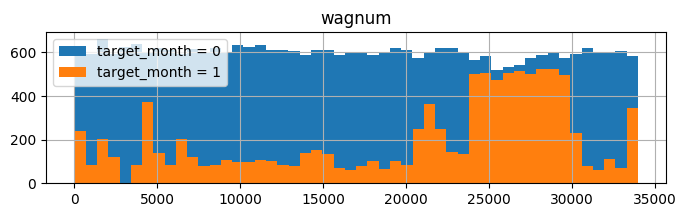

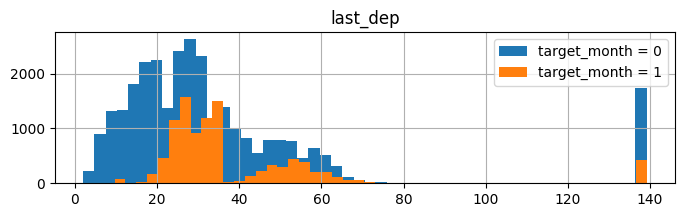

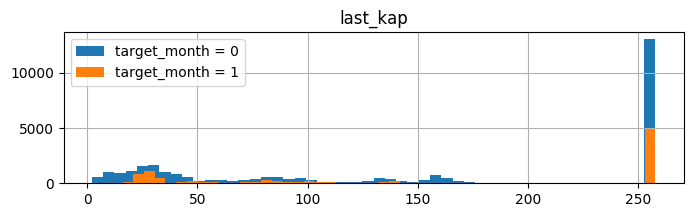

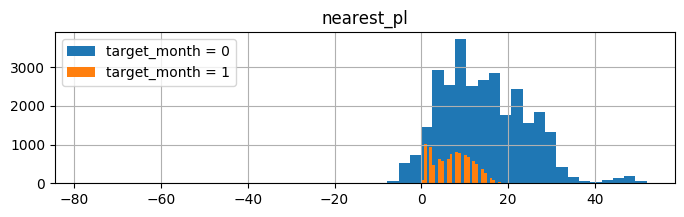

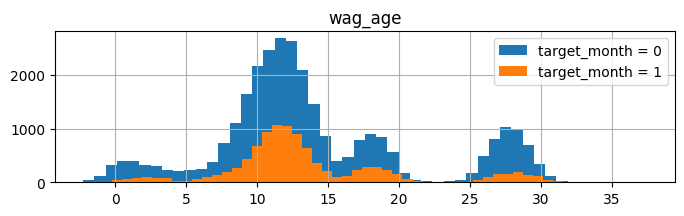

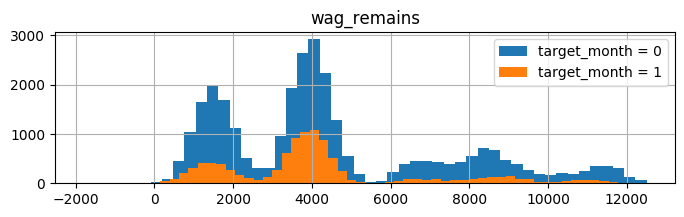

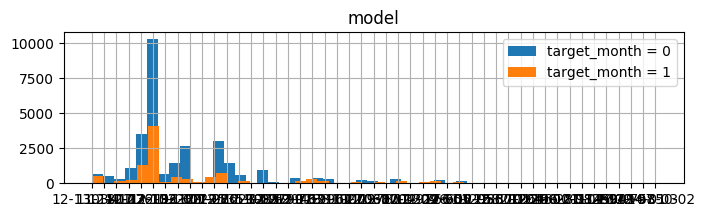

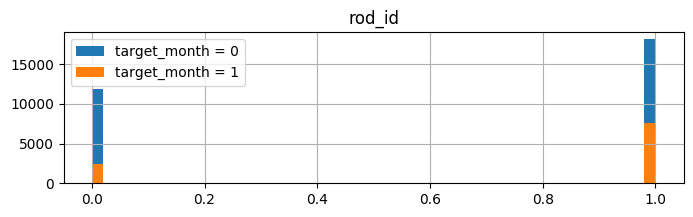

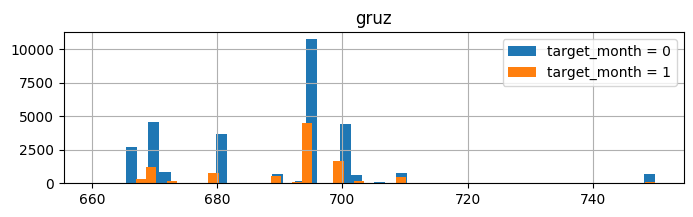

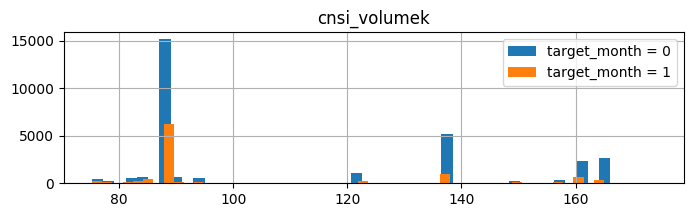

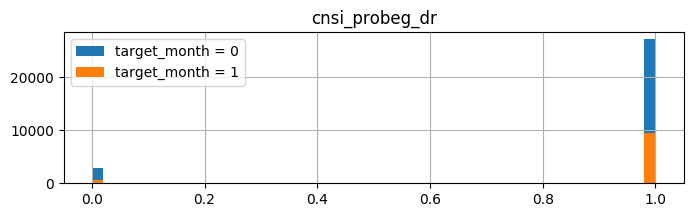

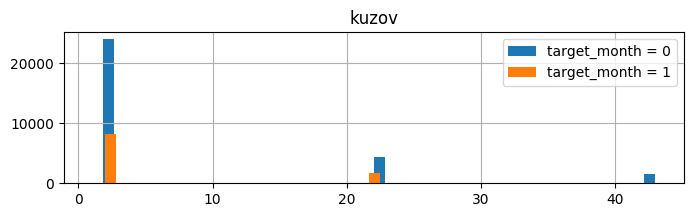

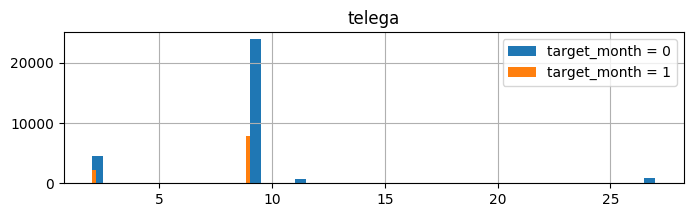

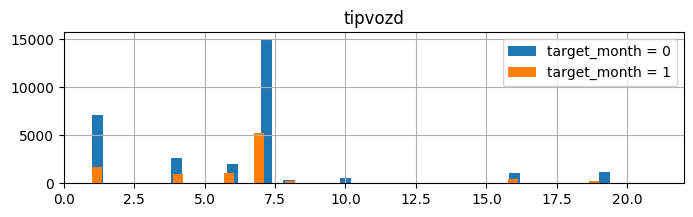

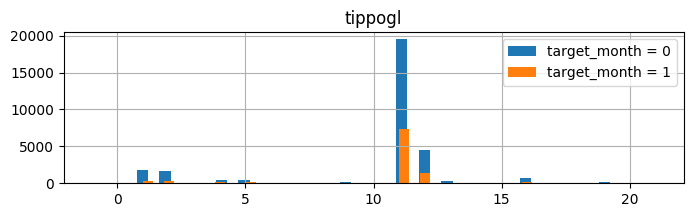

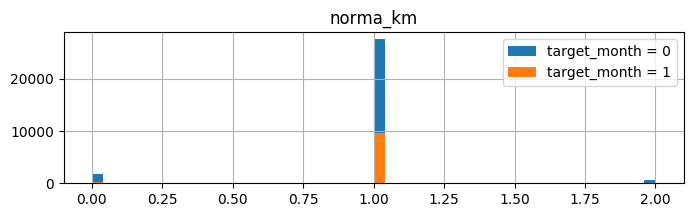

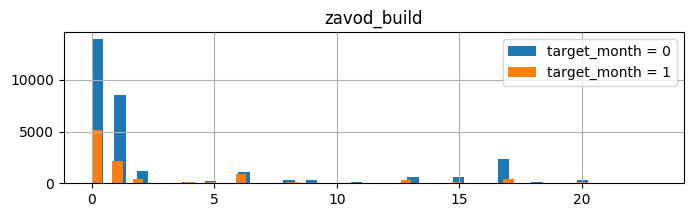

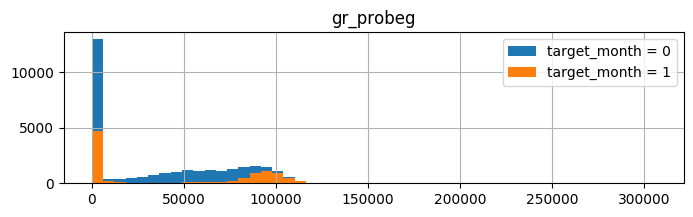

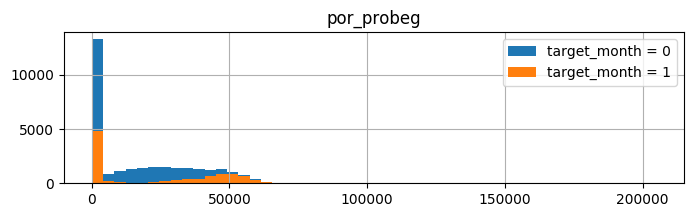

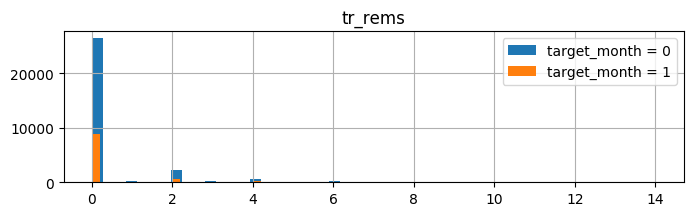

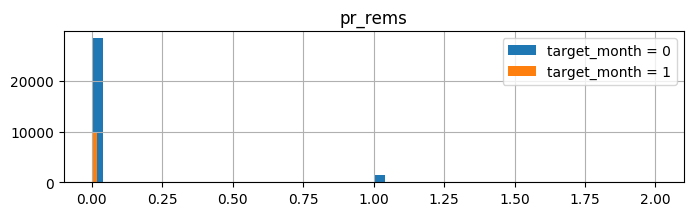

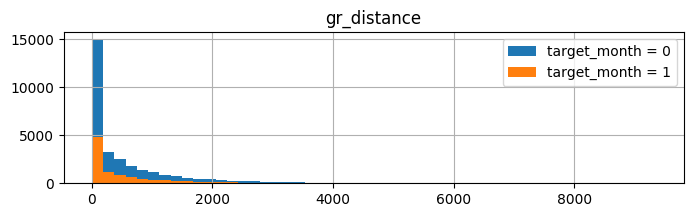

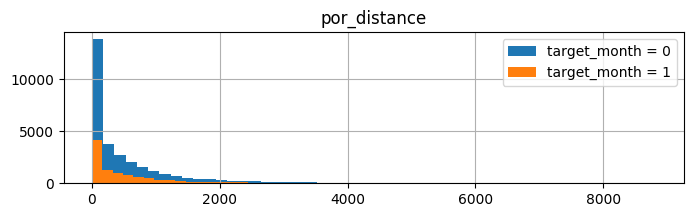

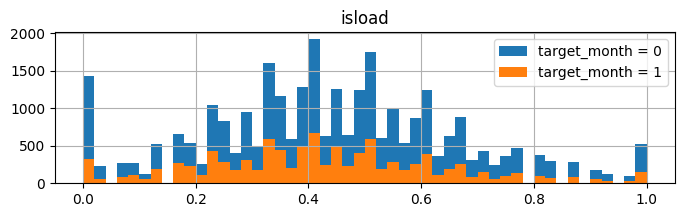

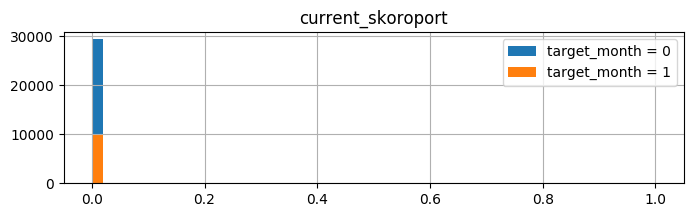

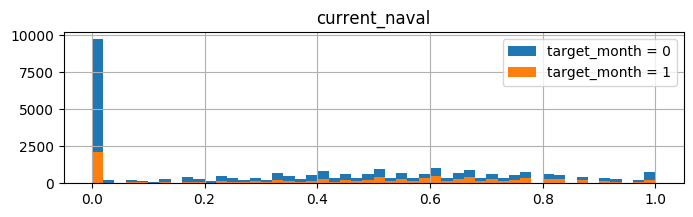

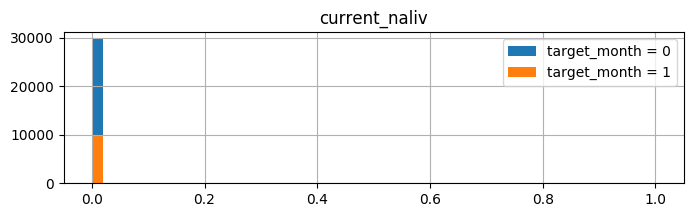

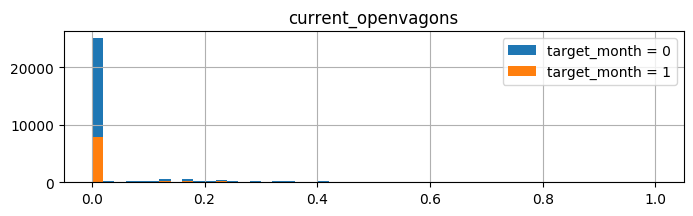

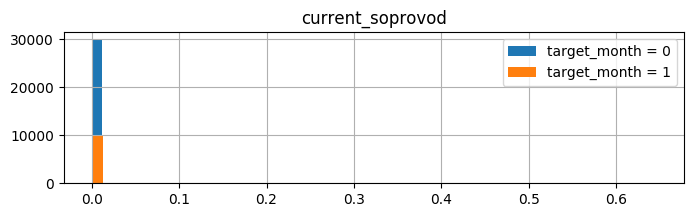

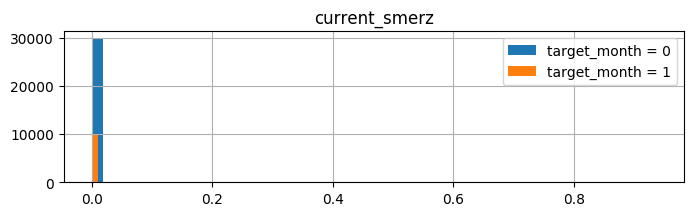

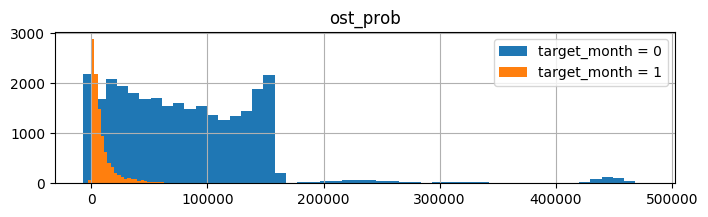

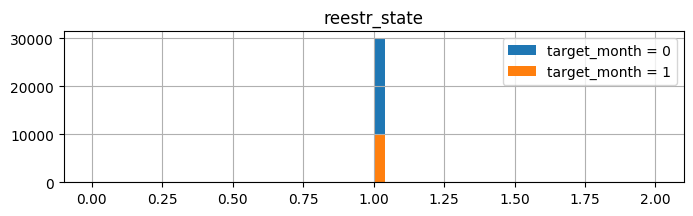

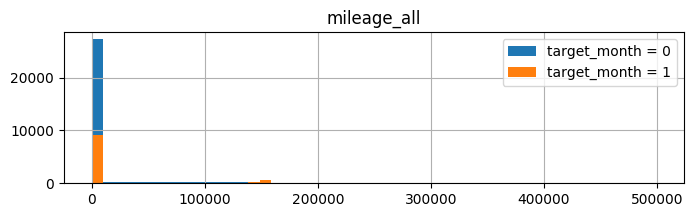

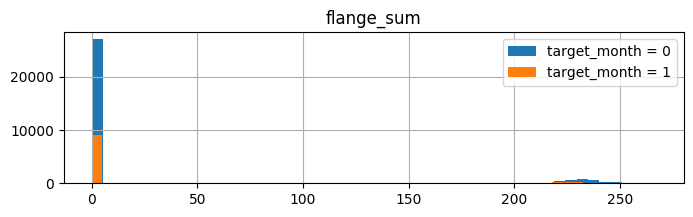

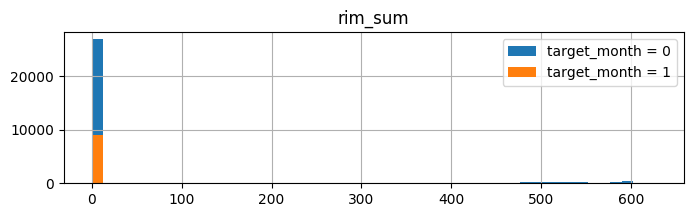

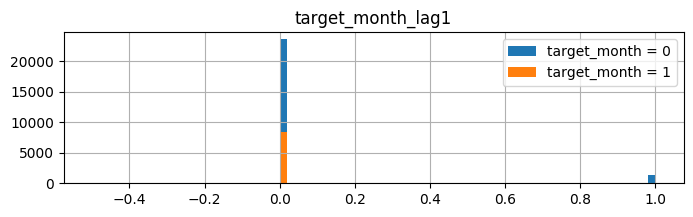

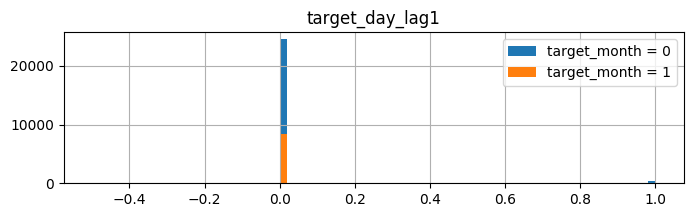

In [128]:
for col in prediction_cols:
    plt.figure(figsize=(8,2), dpi=100)
    df[col][df['target_month'] == 0].sample(30000).hist(bins=50)
    df[col][df['target_month'] == 1].hist(bins=50)
    plt.title(col)
    plt.legend(['target_month = 0', 'target_month = 1'])
    plt.show()

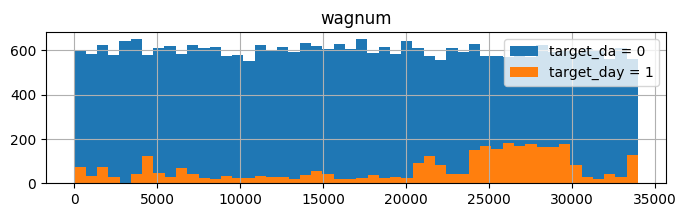

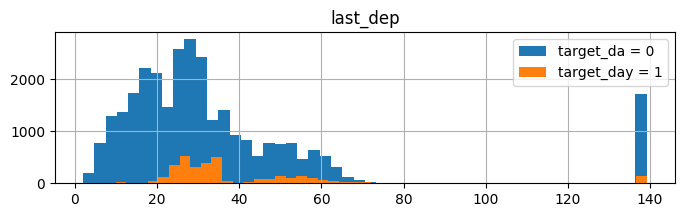

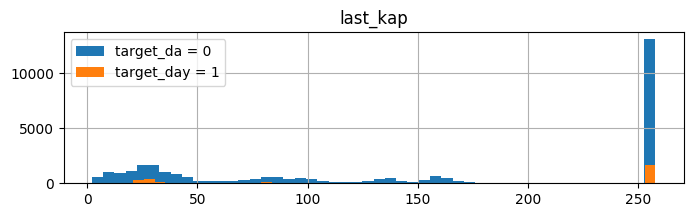

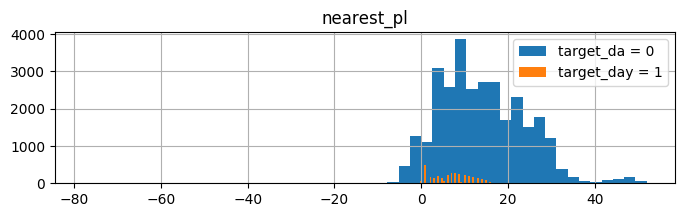

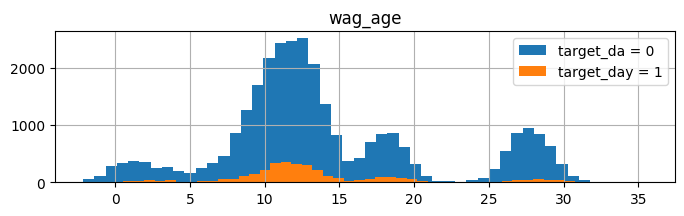

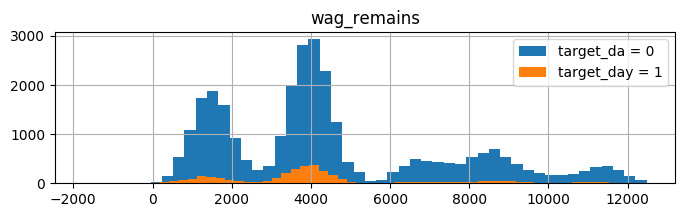

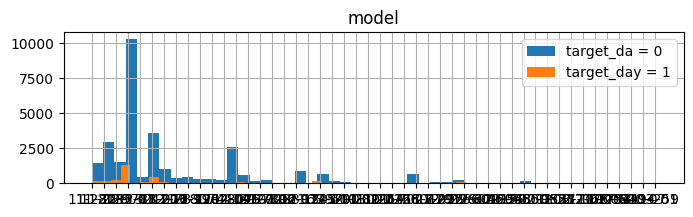

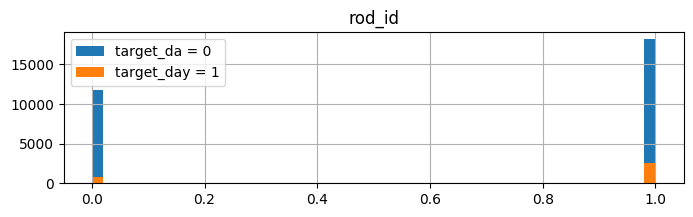

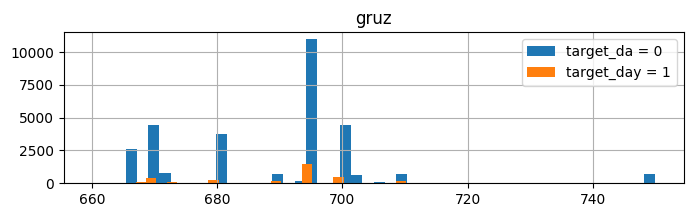

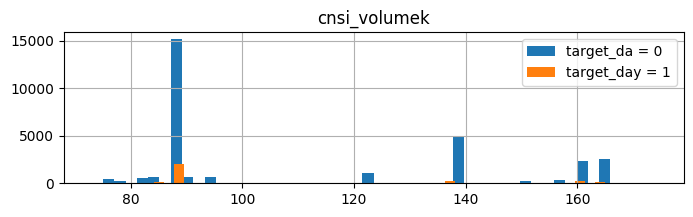

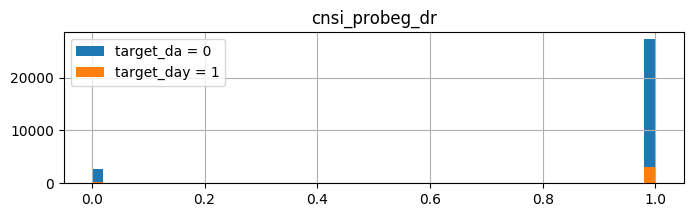

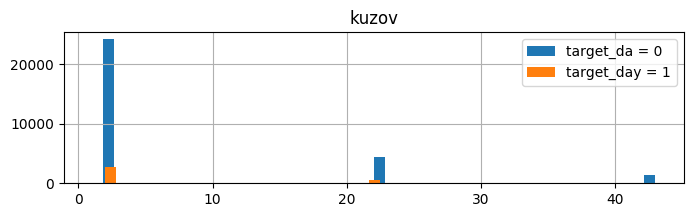

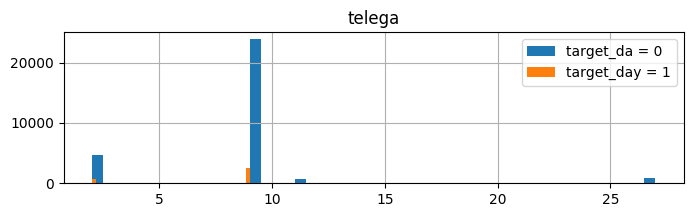

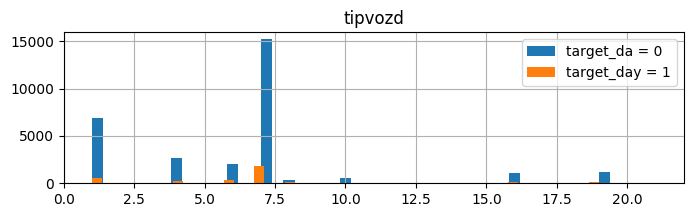

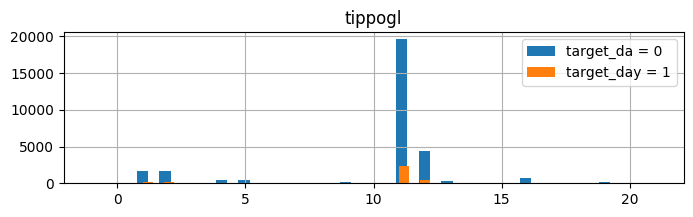

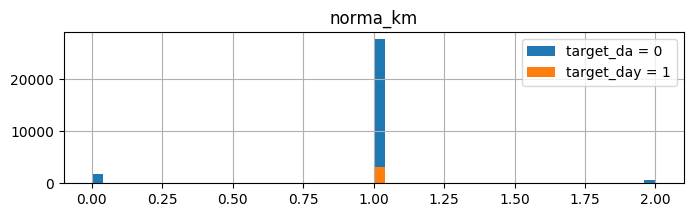

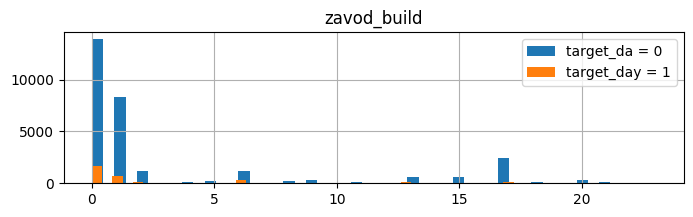

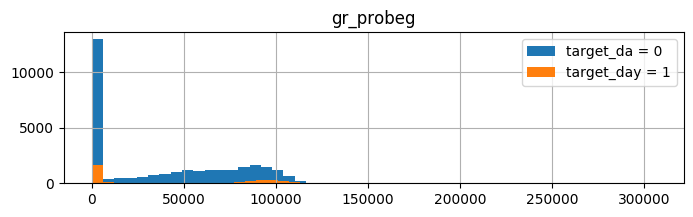

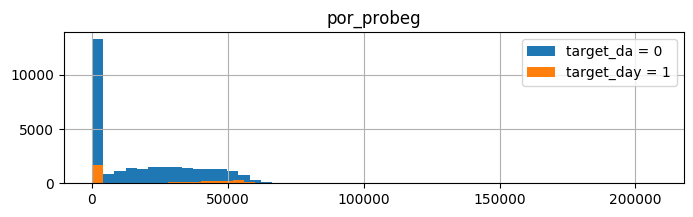

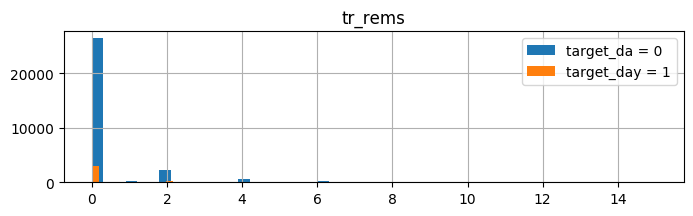

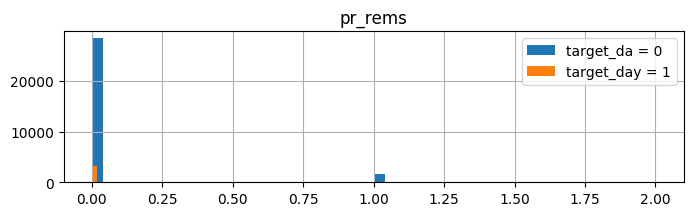

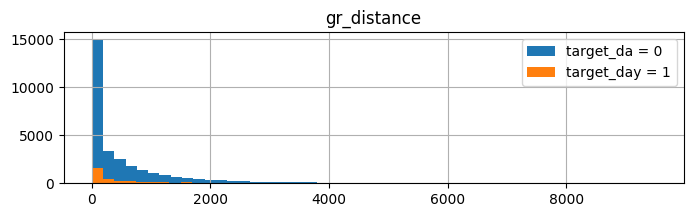

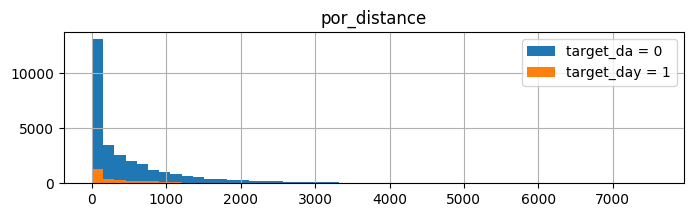

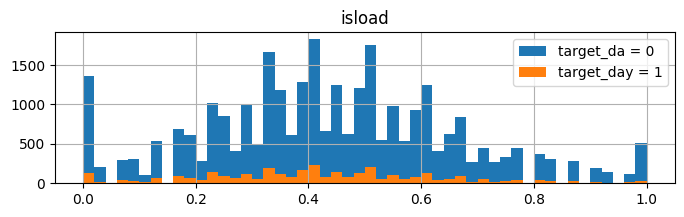

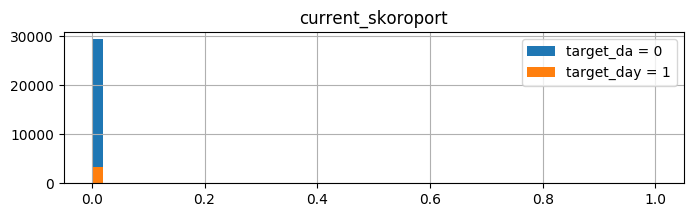

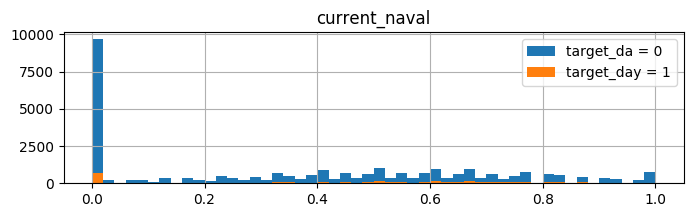

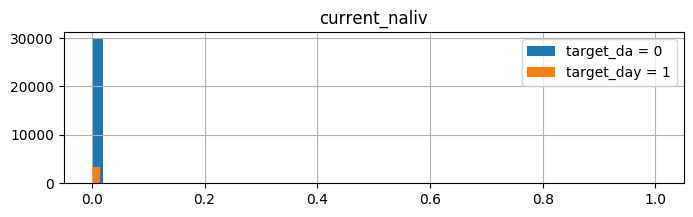

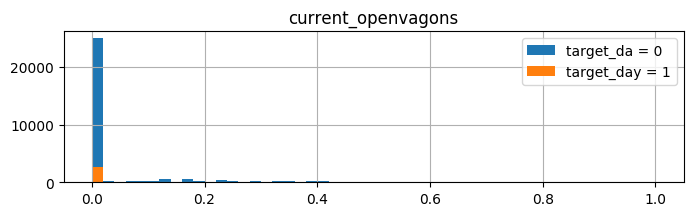

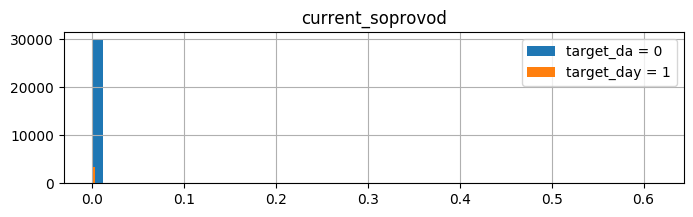

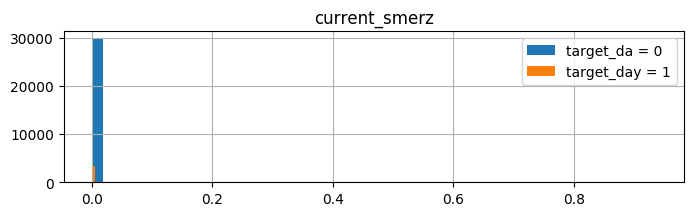

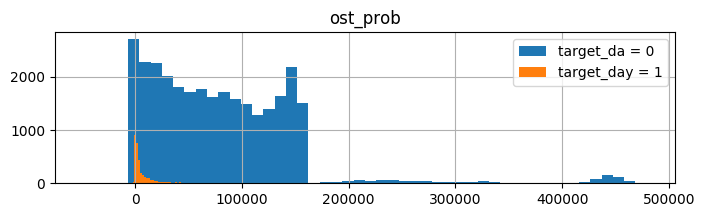

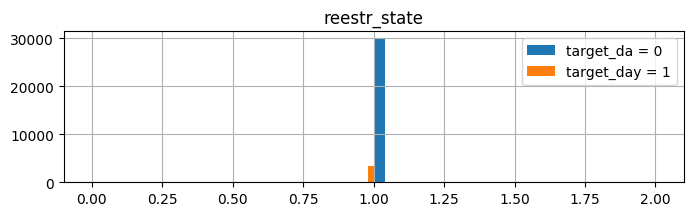

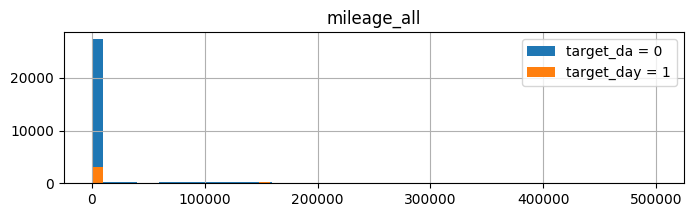

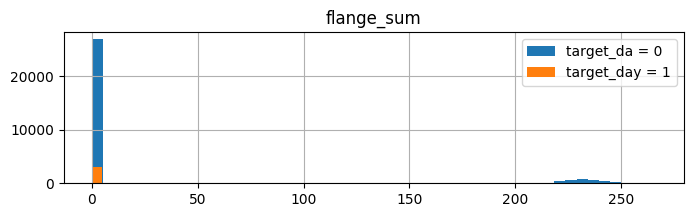

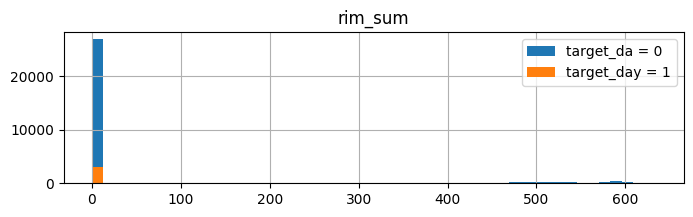

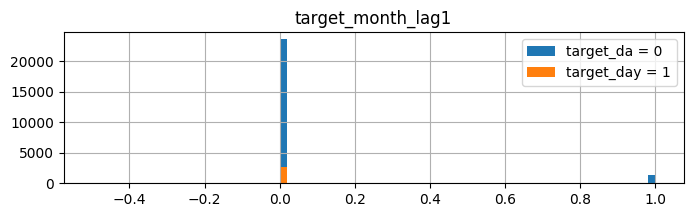

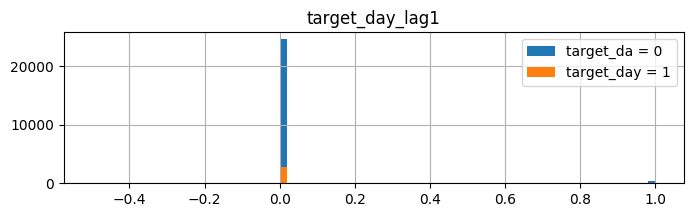

In [129]:
for col in prediction_cols:
    plt.figure(figsize=(8,2), dpi=100)
    df[col][df['target_day'] == 0].sample(30000).hist(bins=50)
    df[col][df['target_day'] == 1].hist(bins=50)
    plt.title(col)
    plt.legend(['target_da = 0', 'target_day = 1'])
    plt.show()

## 2. Прогнозирование по месяцам

In [119]:
train = df[df['current_month'] <= '2022-12-01'].dropna()
val = df[df['current_month'] == '2023-01-01'].dropna()

In [53]:
classes = np.unique(train['target_month'].values)
month_weights = compute_class_weight(
    y=train['target_month'].values,
    classes=classes,
    class_weight={1: 0.6, 0: 0.4}
)

In [54]:
model_month = CatBoostClassifier(
    iterations=50,
    depth=6,
    random_state=102,
    cat_features=cat_cols,
    verbose=10, 
    class_weights=month_weights
)

In [55]:
model_month.fit(
    train[prediction_cols], train['target_month'],
    eval_set=(val[prediction_cols], val['target_month'])
)

Learning rate set to 0.39243
0:	learn: 0.1907504	test: 0.1794607	best: 0.1794607 (0)	total: 33ms	remaining: 1.62s
10:	learn: 0.0808621	test: 0.1006133	best: 0.0995252 (6)	total: 279ms	remaining: 987ms
20:	learn: 0.0774622	test: 0.1015850	best: 0.0995252 (6)	total: 479ms	remaining: 661ms
30:	learn: 0.0755720	test: 0.1015483	best: 0.0995252 (6)	total: 657ms	remaining: 403ms
40:	learn: 0.0735549	test: 0.1006251	best: 0.0995252 (6)	total: 852ms	remaining: 187ms
49:	learn: 0.0718241	test: 0.1008602	best: 0.0995252 (6)	total: 1.02s	remaining: 0us

bestTest = 0.09952521427
bestIteration = 6

Shrink model to first 7 iterations.


In [57]:
month_pred = model_month.predict(val[prediction_cols])

In [135]:
model_results = val[['wagnum', 'forecast_month']].copy()
model_results['probability'] = model_month.predict_proba(val[prediction_cols])[:, 1]

In [145]:
model_results.sort_values(by='probability', ascending=False)[:20].style.background_gradient(cmap='coolwarm', subset=['probability'])

,wagnum,forecast_month,probability
201757,33447,2023-02-01,0.979852
198839,27400,2023-02-01,0.967513
183197,26777,2023-02-01,0.967140
202956,8145,2023-02-01,0.966033
203528,15524,2023-02-01,0.965348
187149,25676,2023-02-01,0.965253
194066,20653,2023-02-01,0.962461
169891,25249,2023-02-01,0.962140
180087,25950,2023-02-01,0.962090
182051,21982,2023-02-01,0.961901


Для анализа результатов моделей была рассмотрена как предложенная метрика f-мера, а также матрица ошибок и метрика fbeta. Метрика fbeta позволяет задать вес более редкому классу в том случае, если редкий класс важнее классифицировать верно. В данном случае, важно определять потенциальные неисправные вагоны и заранее направить их в плановый ремонт. Таким образом, для оценки результата предсказаний был выбран коэффициент beta=2. Как видно из результатов, среди вагонов, которые будут направлены в плановый ремонт в следующем месяце, модель верно выделила 79% вагонов, при этом метрика fbeta показала высокое качество для класса 1 (вагон будет отправлен в плановый ремонт).

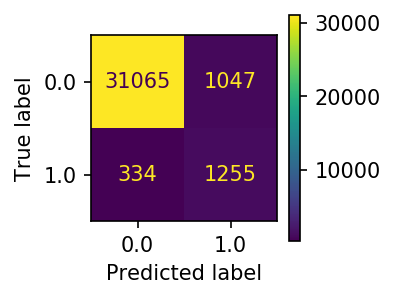

In [96]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
conf_matrix = confusion_matrix(val['target_month'].values, month_pred)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
vis.plot()
plt.show()

In [97]:
f1_score(val['target_month'].values, month_pred)

0.6450783860190182

In [117]:
fbeta_score(val['target_month'].values, month_pred, beta=2)

0.7247632247632247

In [146]:
model_results = val[['wagnum', 'forecast_month']].copy()
model_results['probability'] = model_day.predict_proba(val[prediction_cols])[:, 1]

In [147]:
model_results.sort_values(by='probability', ascending=False)[:20].style.background_gradient(cmap='coolwarm', subset=['probability'])

,wagnum,forecast_month,probability
197173,24462,2023-02-01,0.991548
203655,27857,2023-02-01,0.982182
176489,33904,2023-02-01,0.979901
203827,29970,2023-02-01,0.979184
177073,26871,2023-02-01,0.960092
188727,26050,2023-02-01,0.958500
191614,28617,2023-02-01,0.957607
202769,26212,2023-02-01,0.954943
196191,33846,2023-02-01,0.953158
185206,22973,2023-02-01,0.951104


## 3. Прогнозирование по дням

In [98]:
classes = np.unique(train['target_day'].values)
day_weights = compute_class_weight(
    y=train['target_day'].values,
    classes=classes,
    class_weight={1: 0.8, 0: 0.2}
)

In [99]:
model_day = CatBoostClassifier(
    iterations=50,
    depth=6,
    random_state=102,
    cat_features=cat_cols,
    verbose=10, 
    class_weights=day_weights
)

In [100]:
model_day.fit(
    train[prediction_cols], train['target_day'],
    eval_set=(val[prediction_cols], val['target_day'])
)

Learning rate set to 0.39243
0:	learn: 0.2363713	test: 0.2381302	best: 0.2381302 (0)	total: 40.4ms	remaining: 1.98s
10:	learn: 0.0834214	test: 0.0942234	best: 0.0940021 (9)	total: 278ms	remaining: 984ms
20:	learn: 0.0775649	test: 0.0936188	best: 0.0932489 (16)	total: 480ms	remaining: 663ms
30:	learn: 0.0734683	test: 0.0940191	best: 0.0932489 (16)	total: 670ms	remaining: 410ms
40:	learn: 0.0694620	test: 0.0940412	best: 0.0932489 (16)	total: 865ms	remaining: 190ms
49:	learn: 0.0667008	test: 0.0951522	best: 0.0932489 (16)	total: 1.03s	remaining: 0us

bestTest = 0.09324886023
bestIteration = 16

Shrink model to first 17 iterations.


In [101]:
day_pred = model_day.predict(val[month_cols])

Выявление вагонов, которые будут направлены в плановый ремонт в течение 10 дней, оказалось более сложной задачей, однако модель выявила около 60% таких вагонов.

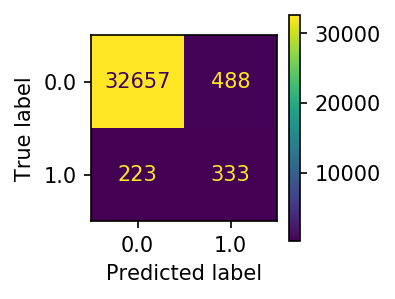

In [102]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
conf_matrix = confusion_matrix(val['target_day'].values, day_pred)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
vis.plot()
plt.show()

In [103]:
f1_score(val['target_day'].values, day_pred)

0.4836601307189543

In [118]:
fbeta_score(val['target_day'].values, day_pred, beta=2)

0.5467980295566502

## 4. Интерпретация работы моделей

На диаграмме показаны признаки, оказывающие наибольшее воздействие на результат работы модели. Признаки хорошо обобщают информацию о целевой переменной, при этом зачастую уменьшение (уменьшение) значение признака приводит к увеличению (уменьшению) вероятности того, что модель выдаст заключение о том, что вагон необходимо (не нужно) отправить в плановый ремонт.

Действительно, при уменьшении остаточного пробега вагона, он скорее попадет в ремонт. 
Схожие результаты демонстрируют модели, предсказывающие, попадание в ремонт в следующем месяце и в следующие 10 дней, однако порядок важности признаков отличается. 

При выявлении зависимостей между признаками и целевой переменной, оказалось, что для прогноза о попадании вагона в ремонт в следующие 10 дней зачастую признаки имеют тесную связь с РПС. При небольшом остаточном пробеге и открытом типе вагона модели "легче" давать корректные предсказания.

In [104]:
train = df[df['current_month'] <= '2023-01-01'].dropna()
test = df[df['current_month'] == '2023-02-01']

In [105]:
model_month.fit(train[month_cols], train['target_month'])

Learning rate set to 0.5
0:	learn: 0.1611567	total: 37.7ms	remaining: 1.84s
10:	learn: 0.0779823	total: 303ms	remaining: 1.07s
20:	learn: 0.0748695	total: 514ms	remaining: 710ms
30:	learn: 0.0724312	total: 730ms	remaining: 447ms
40:	learn: 0.0706368	total: 941ms	remaining: 207ms
49:	learn: 0.0692419	total: 1.13s	remaining: 0us


In [106]:
explainer = shap.TreeExplainer(model_month)
shap_values = explainer.shap_values(train[month_cols], train['target_month'])

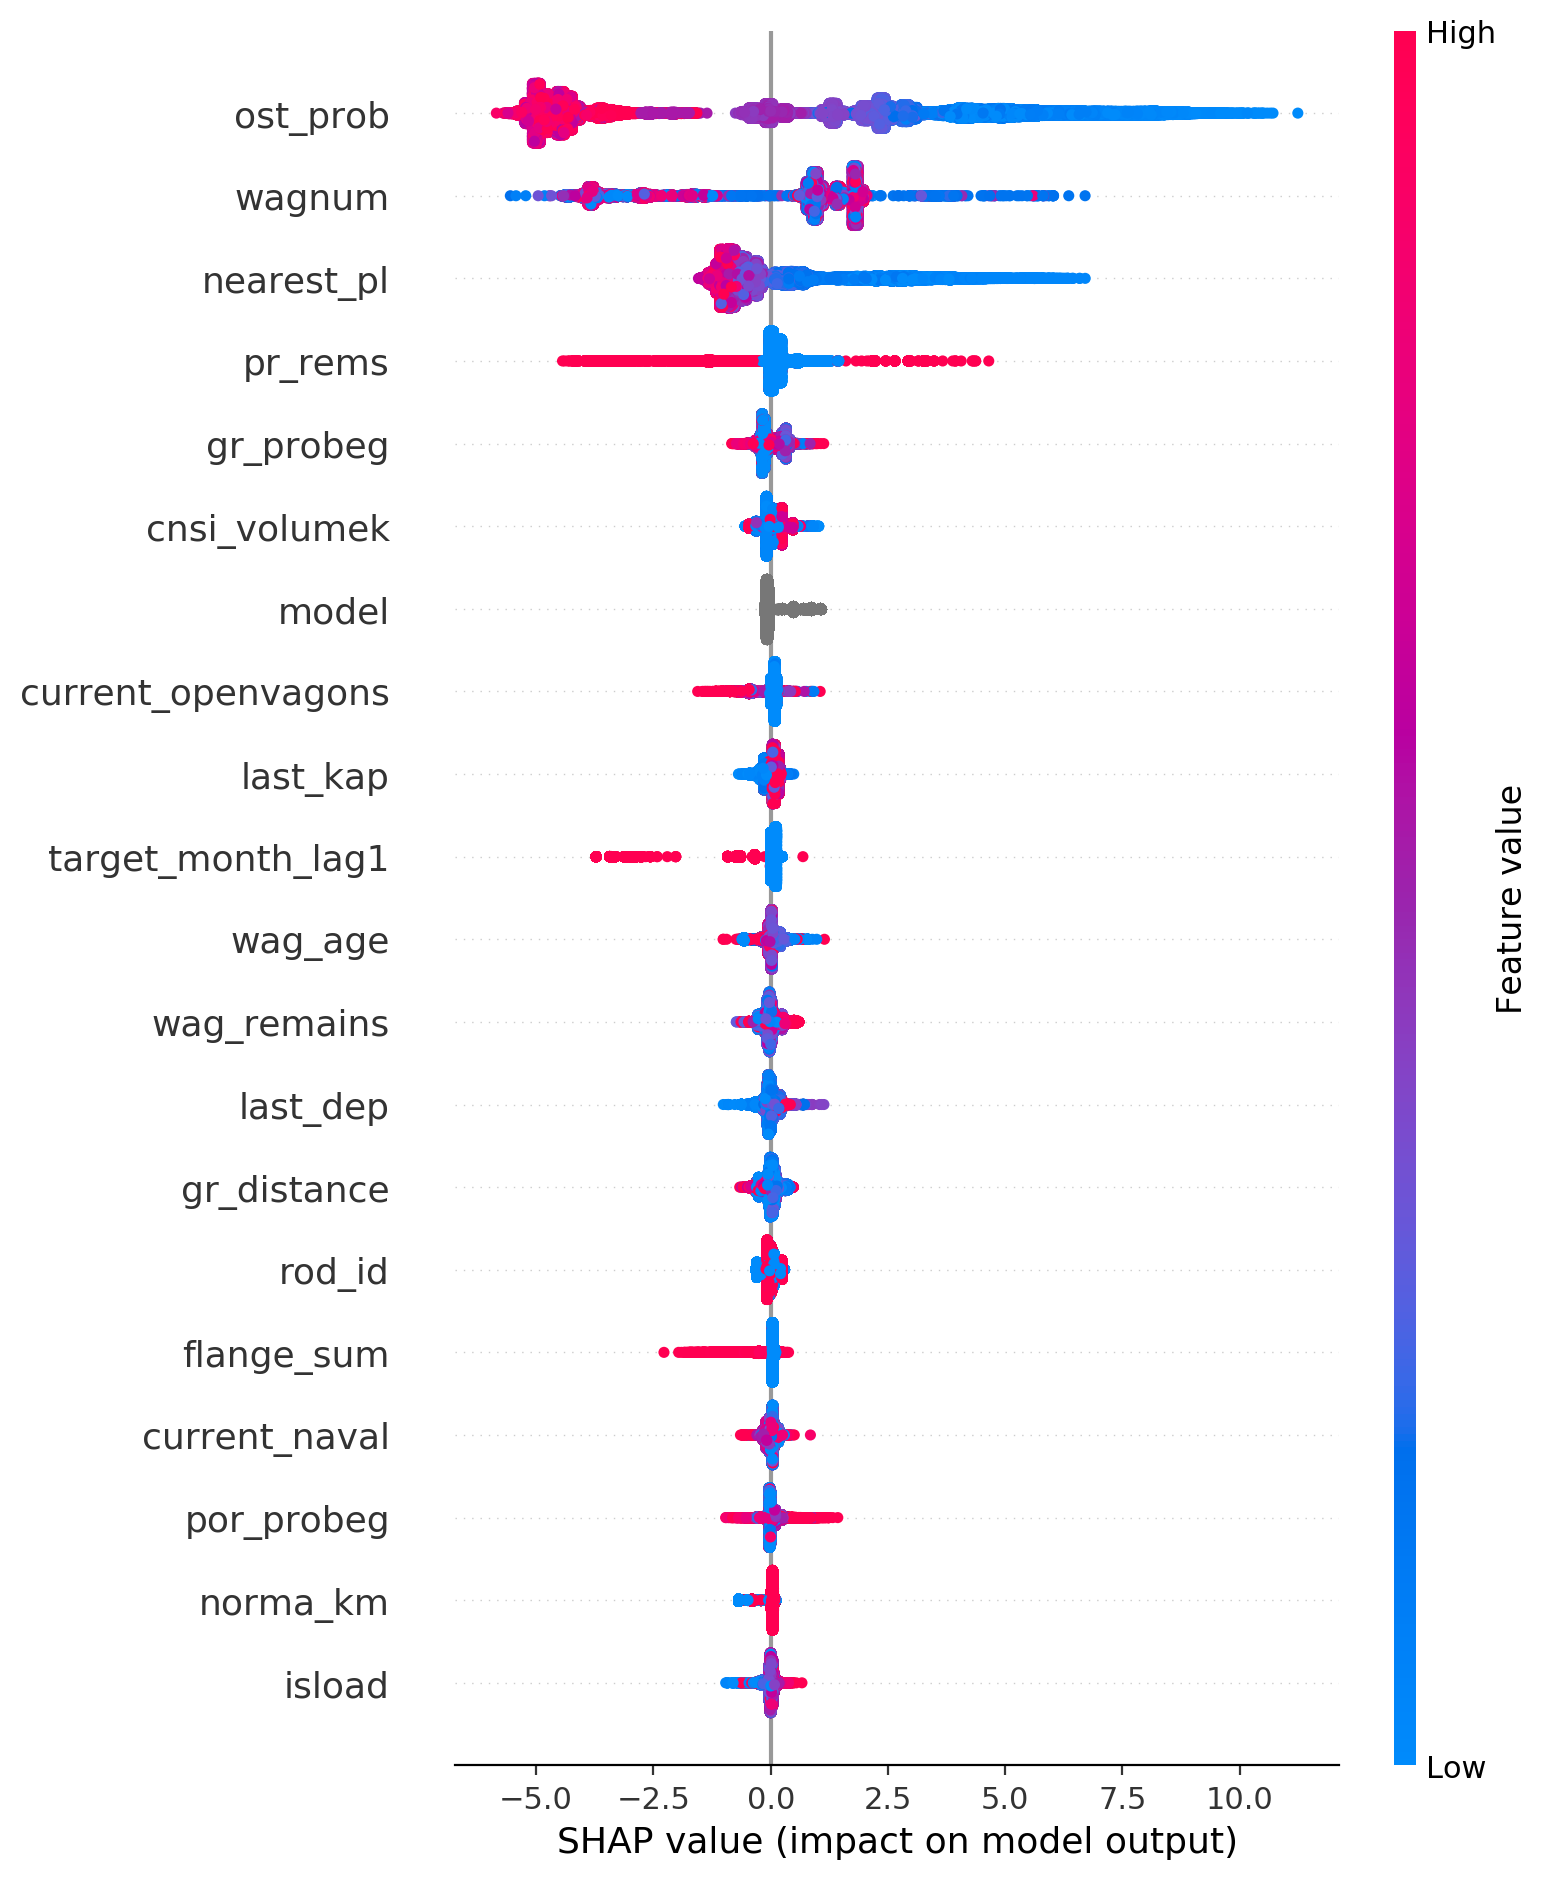

In [107]:
plt.figure(dpi=200)
shap.summary_plot(
    shap_values, 
    train[month_cols].values, 
    feature_names=month_cols, 
    class_names=[0, 1]
)

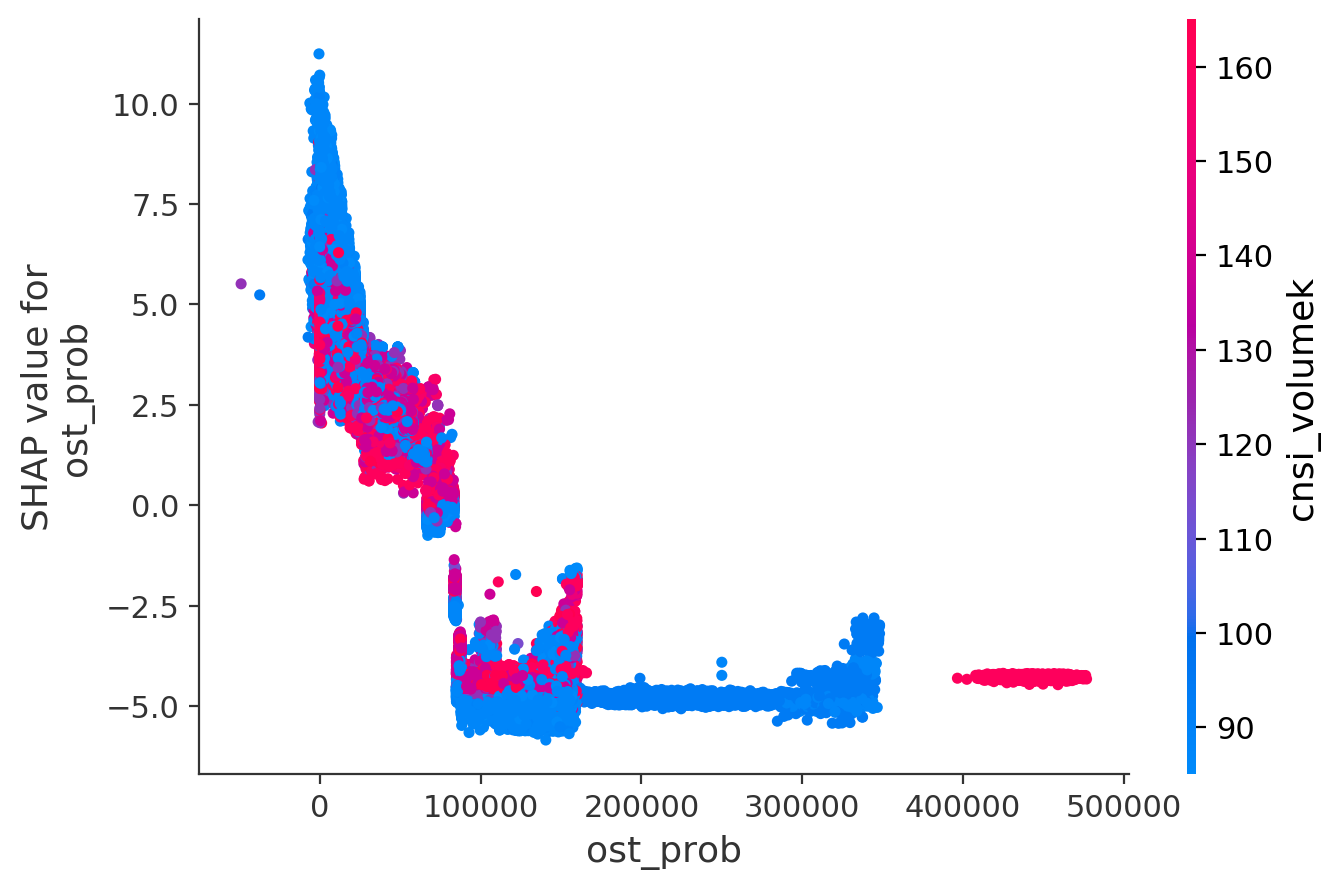

In [108]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
shap.dependence_plot('ost_prob', shap_values, train[month_cols])

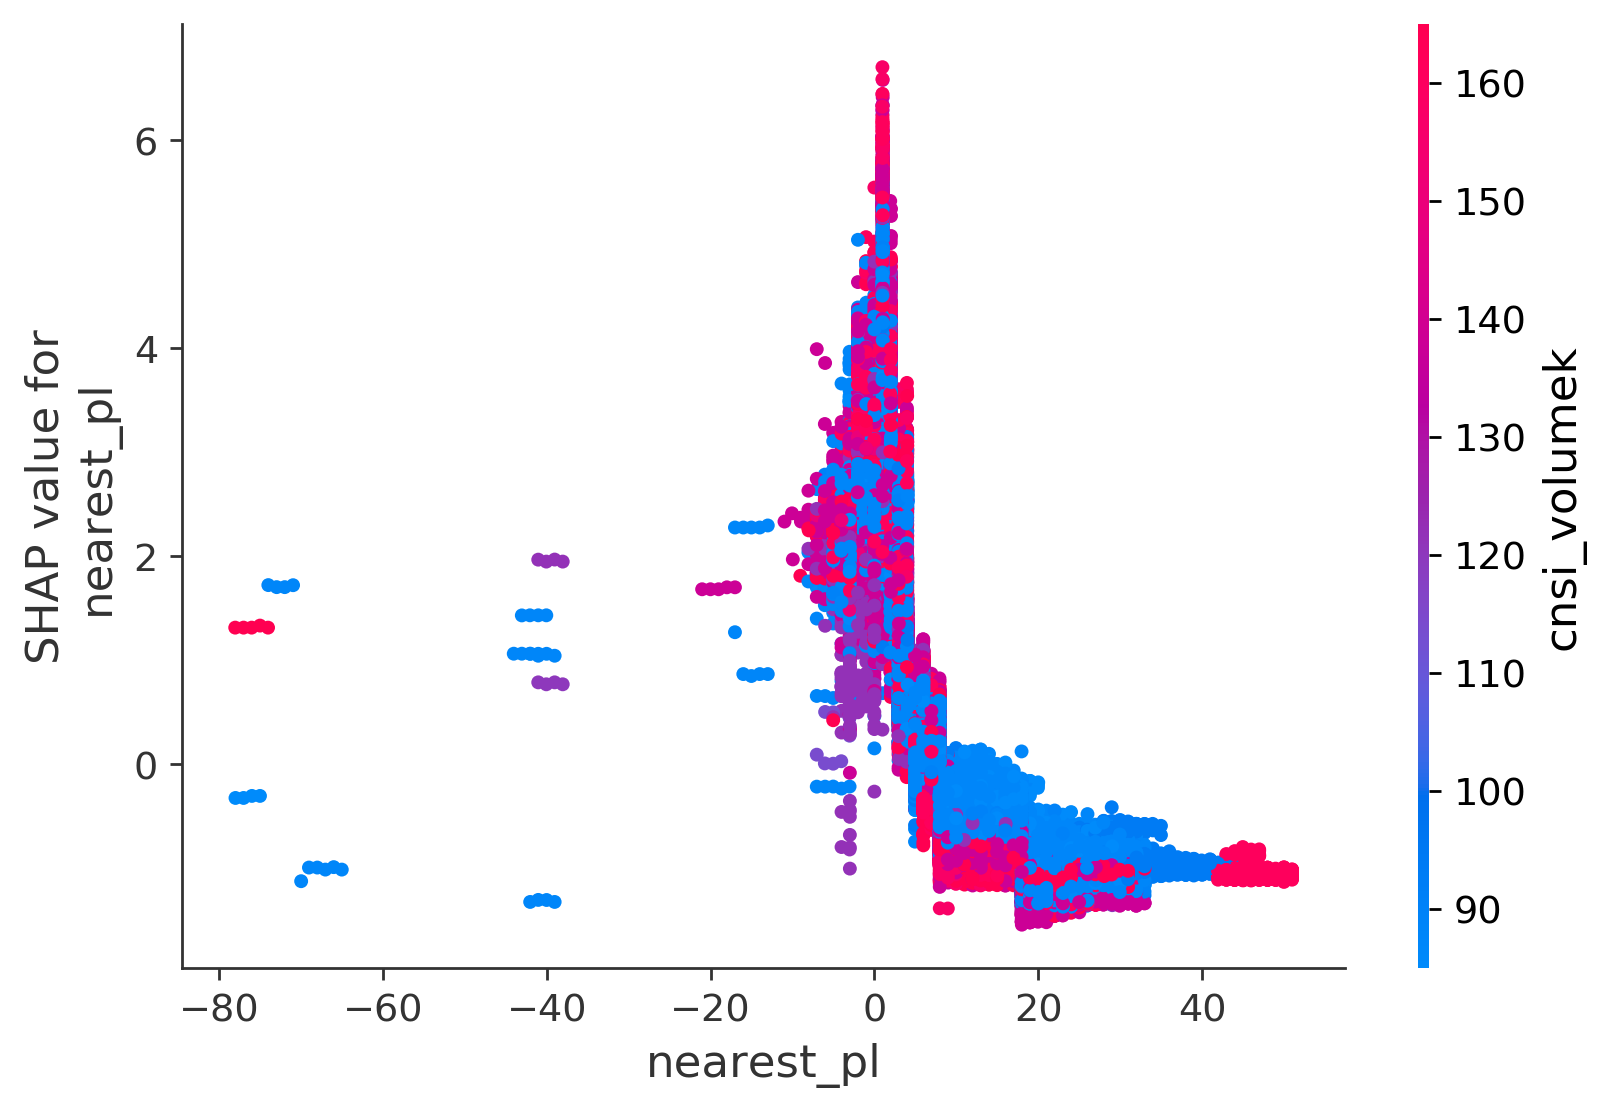

In [109]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
shap.dependence_plot('nearest_pl', shap_values, train[month_cols])

In [110]:
model_day.fit(train[month_cols], train['target_day'])

Learning rate set to 0.5
0:	learn: 0.1775063	total: 36ms	remaining: 1.76s
10:	learn: 0.0828839	total: 291ms	remaining: 1.03s
20:	learn: 0.0780257	total: 516ms	remaining: 713ms
30:	learn: 0.0736250	total: 731ms	remaining: 448ms
40:	learn: 0.0707220	total: 942ms	remaining: 207ms
49:	learn: 0.0674442	total: 1.14s	remaining: 0us


In [111]:
explainer = shap.TreeExplainer(model_day)
shap_values = explainer.shap_values(train[month_cols], train['target_day'])

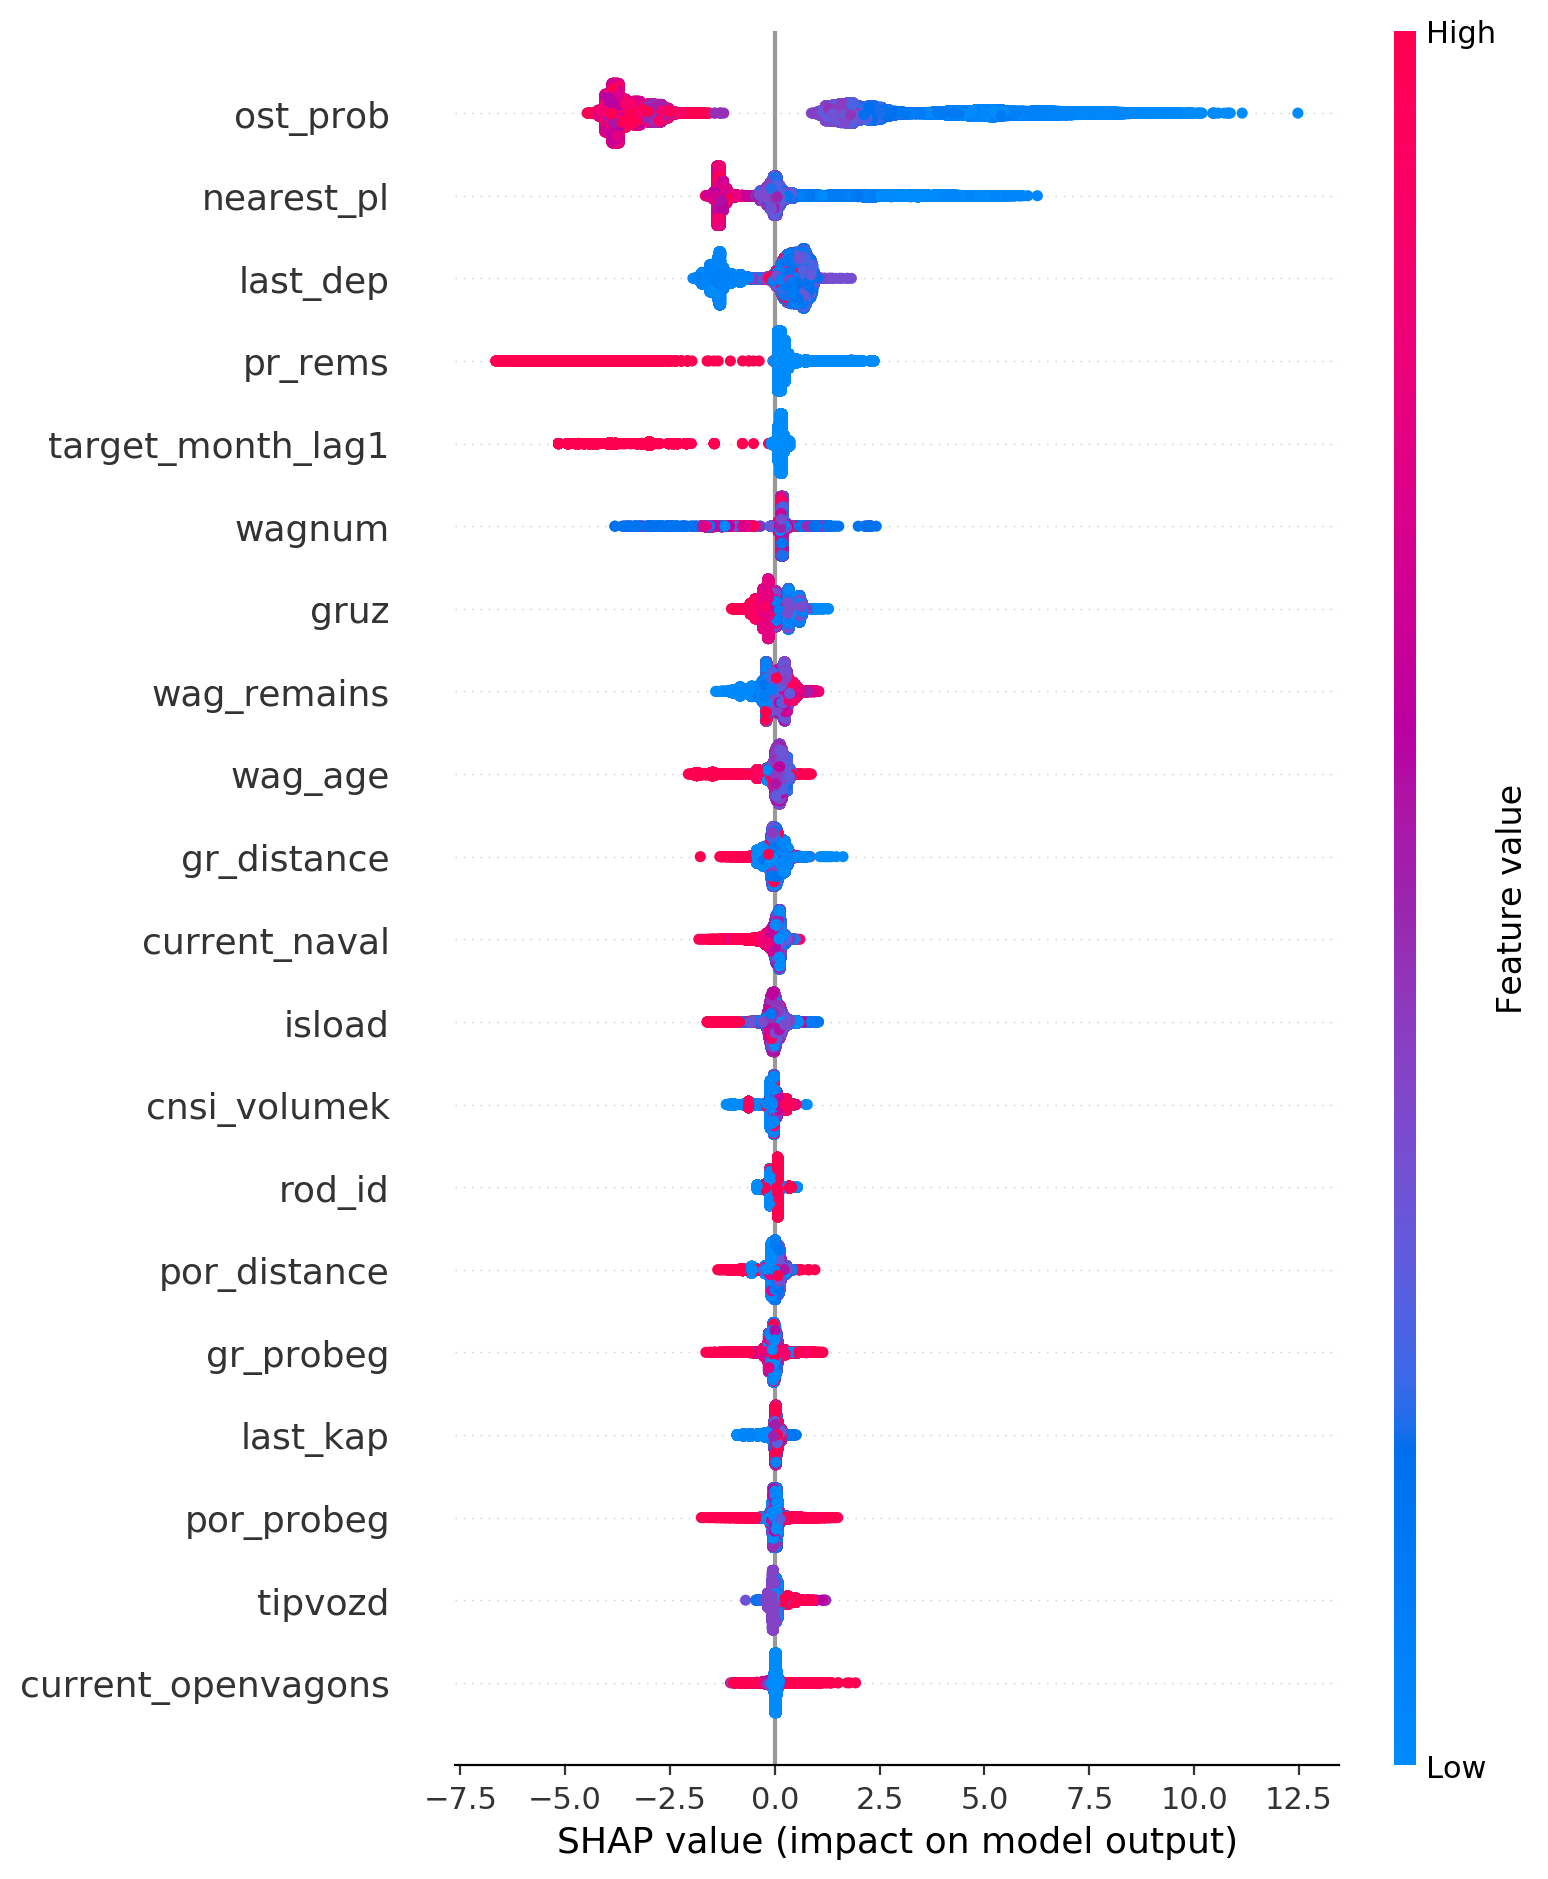

In [112]:
plt.figure(dpi=200)
shap.summary_plot(
    shap_values, 
    train[month_cols].values, 
    feature_names=month_cols, 
    class_names=[0, 1]
)

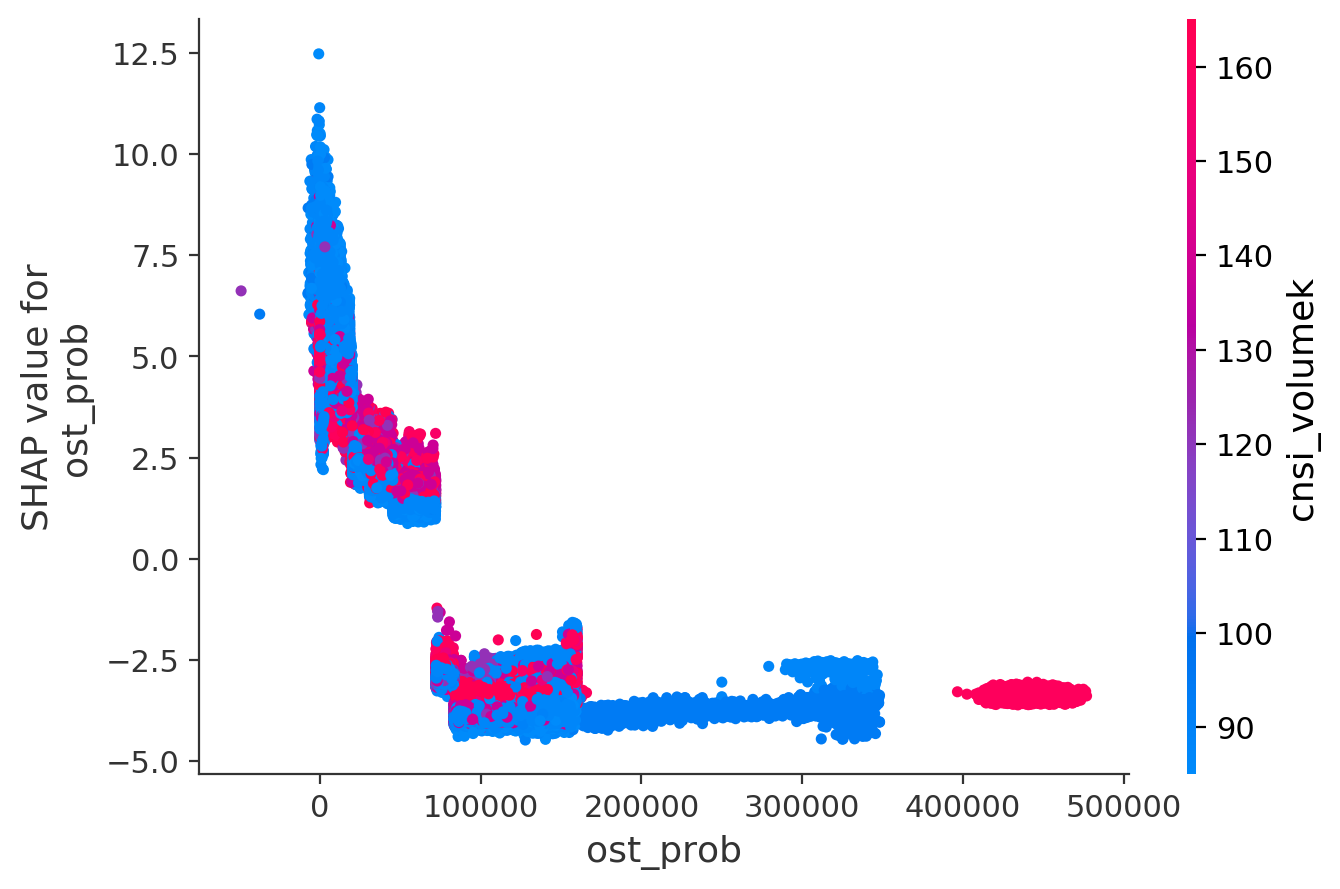

In [113]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
shap.dependence_plot('ost_prob', shap_values, train[month_cols])

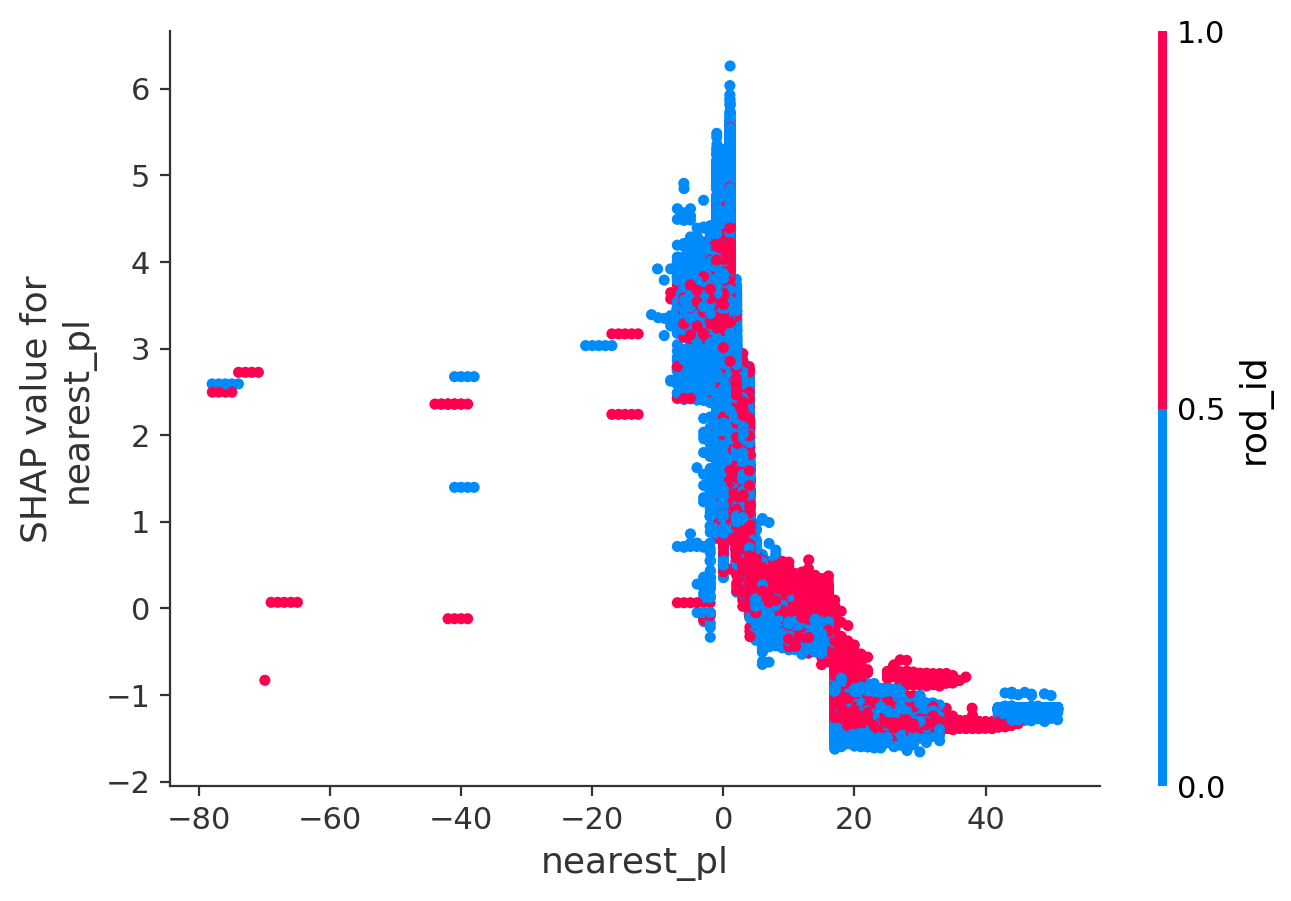

In [114]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
shap.dependence_plot('nearest_pl', shap_values, train[month_cols])

Таким образом, при оценке экспертом необходимости отцепки вагона в плановый ремонт ему могут быть предоставлены оценки вероятностей попадания вагонов в ремонт, а также возможность интерпретации, по какой причине вагон был выделен моделью.